In [46]:
import cv2
import glob, os
from PIL import Image, ImageFilter
import numpy as np
import matplotlib.pyplot as plt
from skimage import io, filters
from scipy import ndimage
from skimage import measure
from scipy.stats import norm
import networkx as nx
from networkx.algorithms.flow import edmonds_karp

In [10]:
# DIR = ...

In [11]:
chosen_frames = []
other_images = []

In [12]:
os.chdir(DIR + "chosen_frames")
for file in glob.glob("*.jpg"):
    chosen_frames.append(Image.open(file))
    
os.chdir(DIR + "other_images")
for file in glob.glob("*.jpg"):
    other_images.append(Image.open(file))

In [13]:
frames = []
for fi in chosen_frames:
    w, h = fi.size
    frames.append(fi.crop((0, 240, 500, h-50)))

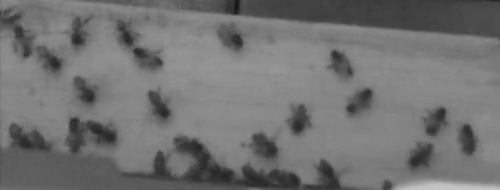

In [14]:
bees = frames[0]
gray = bees.convert('L') 

In [17]:
foreground = Image.open(DIR + 'foreground.png')
background = Image.open(DIR + 'background.png')

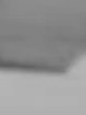

In [27]:
background.getchannel('G')

In [28]:
# we consider a 'G' channel which is the most useful in distinguishing foreground and background
foreground_data = np.array(foreground.getchannel('G'))
background_data = np.array(background.getchannel('G'))

In [29]:
foreground_data = foreground_data.reshape(foreground_data.shape[0] * foreground_data.shape[1], 1)
background_data = background_data.reshape(background_data.shape[0] * background_data.shape[1], 1)

In [32]:
mu1, std1 = norm.fit(foreground_data)
mu2, std2 = norm.fit(background_data)

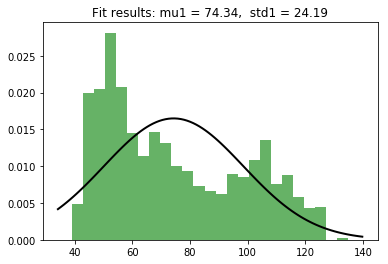

In [33]:
# Plot the histogram for the foreground data
plt.hist(foreground_data, bins=25, density=True, alpha=0.6, color='g')

# Plot the PDF.
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu1, std1)
plt.plot(x, p, 'k', linewidth=2)
title = "Fit results: mu1 = %.2f,  std1 = %.2f" % (mu1, std1)
plt.title(title)

plt.show()

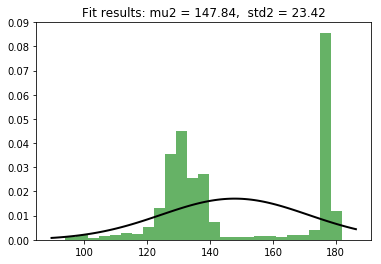

In [34]:
# Plot the histogram for the background data
plt.hist(background_data, bins=25, density=True, alpha=0.6, color='g')

# Plot the PDF.
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu2, std2)
plt.plot(x, p, 'k', linewidth=2)
title = "Fit results: mu2 = %.2f,  std2 = %.2f" % (mu2, std2)
plt.title(title)

plt.show()

In [35]:
def get_probability(mu, std, value):
    # given a 'mu' and 'std' parameters describing normal distribution
    # we calculate the probability of 'value'
    # to belong to this dataset
    return norm(mu, std).pdf(value)

In [44]:
def get_distributions():
    foreground = Image.open(DIR + 'foreground.png')
    background = Image.open(DIR + 'background.png')
    
    foreground_data = np.array(foreground.getchannel('G'))
    background_data = np.array(background.getchannel('G'))
    
    foreground_data = foreground_data.reshape(foreground_data.shape[0] * foreground_data.shape[1], 1)
    background_data = background_data.reshape(background_data.shape[0] * background_data.shape[1], 1)
    
    mu1, std1 = norm.fit(foreground_data)
    mu2, std2 = norm.fit(background_data)
    
    return mu1, std1, mu2, std2

In [37]:
def create_graph(arr, mu1, std1, mu2, std2):
    G = nx.DiGraph()
    
    # defining vertex set
    for i in range(arr.shape[0]):
        for j in range(arr.shape[1]):
            G.add_node((i,j))
    G.add_node('s')
    G.add_node('t')
    
    # definig edges set with proper weigths (capacities)
    for i1 in range(arr.shape[0]):
        for j1 in range(arr.shape[1]):
            for i2 in range(i1, arr.shape[0]):
                for j2 in range(j1, arr.shape[1]):
                    if (i1 == i2 and j1 == j2 - 1) or (i1 == i2 - 1 and j1 == j2):
                        capacity = np.exp((-0.5 * 1./((std1 + std2)/2.)**2)) * ((arr[i1,j1] - arr[i2,j2])**2)
                        G.add_edge((i1,j1), (i2,j2), capacity=capacity)
                        G.add_edge((i2,j2), (i1,j1), capacity=capacity)

    # capacities of (s, e) and (e, t)
    for i in range(arr.shape[0]):
        for j in range(arr.shape[1]):
            cap_s = get_probability(mu1, std1, arr[i, j])
            cap_t = get_probability(mu2, std2, arr[i, j])
            cap_sum = cap_s + cap_t
            G.add_edge('s', (i,j), capacity = 2 * cap_s / cap_sum)
            G.add_edge((i,j), 't', capacity = 2 * cap_t / cap_sum)
            
    return G

In [38]:
def get_bitmap(R, threshold, dimx, dimy):
    bitmap = np.zeros((dimx, dimy))
    for i in range(dimx):
        for j in range(dimy):
            if R['s'][(i,j)]['flow'] > threshold:
                bitmap[i][j] = 1
    return bitmap

In [61]:
def image_processing_pipeline(image):
    # image is a np.array, in RGB model
    width, height, depth = image.shape

    result_image = np.zeros((width, height, depth))
    
    mu1, std1, mu2, std2 = get_distributions()
    
    w_coords = list(range(0, width, 32))
    h_coords = list(range(0, height, 32))
    
    if w_coords[-1] != width - 1:
        w_coords.append(width-1)
    if h_coords[-1] != height - 1:
        h_coords.append(height-1)

    for d in range(depth):
        # we split the image into w_coords x h_coords subimages
        for w in range(len(w_coords) - 1): # not considering last element
            for h in range(len(h_coords) - 1):
                arr = image[w_coords[w]:w_coords[w+1], h_coords[h]:h_coords[h+1], d]
                
                G = create_graph(arr, mu1, std1, mu2, std2)
                
                R = edmonds_karp(G, 's', 't')
                
                print('Current flow:', R.graph['flow_value'], end=' ')
                
                dimx = w_coords[w+1] - w_coords[w]
                dimy = h_coords[h+1] - h_coords[h]
                bitmap = get_bitmap(R, 0.3, dimx, dimy)
                
                arr2 = arr * bitmap
                
                result_image[w_coords[w]:w_coords[w+1], h_coords[h]:h_coords[h+1], d] = arr2
                
                print('Slice {}:{},{}:{},{} done!'.format(w_coords[w], w_coords[w+1], h_coords[h], h_coords[h+1], d))
                
    return result_image

In [62]:
im_g = np.array(gray)
im_arr = im_g.reshape((190,500,1))

In [63]:
result = image_processing_pipeline(im_arr)

/home/pawel/anaconda3/envs/Studies/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: overflow encountered in ubyte_scalars


Current flow: 651.8799604963839 Slice 0:32,0:32,0 done!
Current flow: 468.6727790596038 Slice 0:32,32:64,0 done!
Current flow: 720.1652924356652 Slice 0:32,64:96,0 done!
Current flow: 651.1897679461008 Slice 0:32,96:128,0 done!
Current flow: 726.791679209512 Slice 0:32,128:160,0 done!
Current flow: 624.417051277868 Slice 0:32,160:192,0 done!
Current flow: 478.63763168053487 Slice 0:32,192:224,0 done!
Current flow: 603.2871614894052 Slice 0:32,224:256,0 done!
Current flow: 402.3128029165536 Slice 0:32,256:288,0 done!
Current flow: 357.96864700232015 Slice 0:32,288:320,0 done!
Current flow: 325.22275830119196 Slice 0:32,320:352,0 done!
Current flow: 231.87868809952724 Slice 0:32,352:384,0 done!
Current flow: 103.27440372538327 Slice 0:32,384:416,0 done!
Current flow: 10.276546579525059 Slice 0:32,416:448,0 done!
Current flow: 12.326434626760378 Slice 0:32,448:480,0 done!
Current flow: 9.054544624909786 Slice 0:32,480:499,0 done!
Current flow: 605.7668229897241 Slice 32:64,0:32,0 done!
Cu

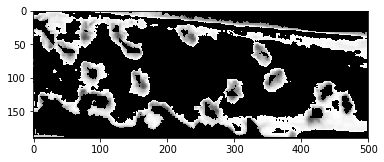

In [64]:
result = result.reshape((190,500))
plt.imshow(result, interpolation='nearest', cmap='gray')